In [1]:
import importlib

import microexpression_env
importlib.reload(microexpression_env)
from microexpression_env import MicroExpressionEnvironment

import agents
importlib.reload(agents)
from agents import LBP_TOP_DDQNAgent


Episode: 0, Total Reward: -1120, Epsilon: 0.9999
Episode: 1, Total Reward: -400, Epsilon: 0.9998000100000001
Episode: 2, Total Reward: -541, Epsilon: 0.9997000299990001
Episode: 3, Total Reward: -100, Epsilon: 0.9996000599960002
Episode: 4, Total Reward: -680, Epsilon: 0.9995000999900007
Episode: 5, Total Reward: -800, Epsilon: 0.9994001499800017
Episode: 6, Total Reward: -1010, Epsilon: 0.9993002099650037
Episode: 7, Total Reward: -700, Epsilon: 0.9992002799440072
Episode: 8, Total Reward: -1120, Epsilon: 0.9991003599160128
Episode: 9, Total Reward: -1300, Epsilon: 0.9990004498800211
Episode: 10, Total Reward: -790, Epsilon: 0.9989005498350332
Episode: 11, Total Reward: -1400, Epsilon: 0.9988006597800497
Episode: 12, Total Reward: -900, Epsilon: 0.9987007797140718
Episode: 13, Total Reward: -790, Epsilon: 0.9986009096361004
Episode: 14, Total Reward: -200, Epsilon: 0.9985010495451367
Episode: 15, Total Reward: -400, Epsilon: 0.9984011994401822
Episode: 16, Total Reward: -700, Epsilon:

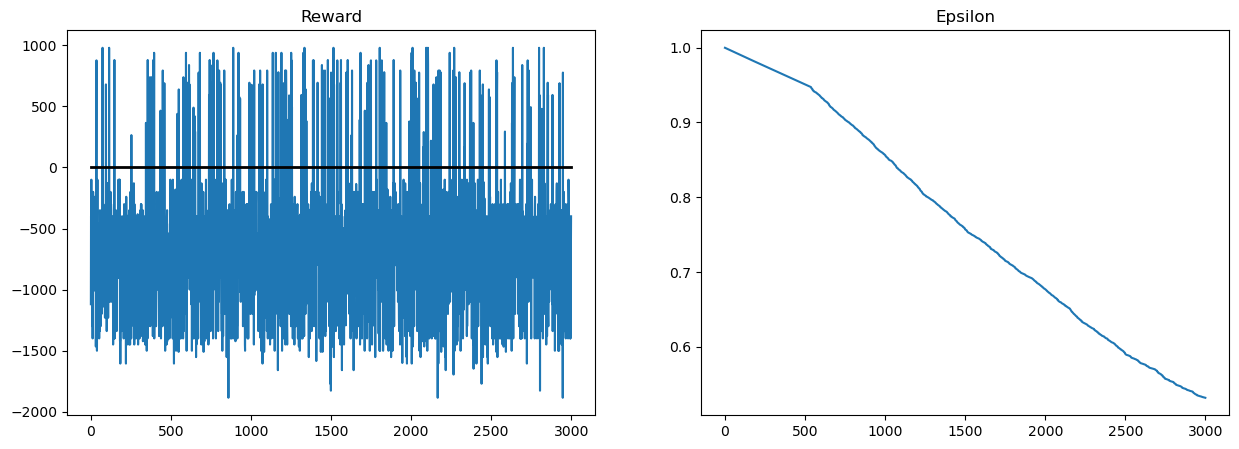

In [8]:
import numpy as np
import torch
from microexpression_env import MicroExpressionEnvironment
from agents import LBP_TOP_DDQNAgent
from collections import deque
import os
import matplotlib.pyplot as plt

data_path = 'face_aligned_episodes'
image_size = (224, 224)
binary_reward = False
big_reward = 1000
penalty = -100

state_dim = 2 * 8  # 2 LBP-TOP histograms (reference and current) with 10 bins each
action_dim = 2
lr = 1e-2
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9999
batch_size = 1024
memory_capacity = 10000
update_target_interval = 100
max_episodes = 3000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = MicroExpressionEnvironment(data_path, image_size, binary_reward, big_reward, penalty)
agent = LBP_TOP_DDQNAgent(state_dim, action_dim, lr, gamma, epsilon_start, epsilon_end, epsilon_decay)
agent.q_network.to(device)
agent.target_network.to(device)

replay_memory = deque(maxlen=memory_capacity)
epsilon_steps = 0
reward_history = []
eps_history = []

for episode in range(max_episodes):
    state = env.reset()
    reference_frame = state
    state_lbp_top = agent.get_lbp_top_feature(reference_frame, state)
    state_tensor = torch.tensor([state_lbp_top], dtype=torch.float32).to(device)
    #print(state_tensor.shape)
    total_reward = 0
    step = 0
    while True:
        action = agent.select_action(state_tensor)
        next_state, reward, terminated, truncated = env.step(action)
        next_state_lbp_top = agent.get_lbp_top_feature(reference_frame, next_state)
        next_state_tensor = torch.tensor([next_state_lbp_top], dtype=torch.float32).to(device)
        total_reward += reward

        replay_memory.append((state_tensor, action, reward, next_state_tensor, terminated))
        state = next_state
        state_tensor = next_state_tensor
        if terminated or truncated:
            break
        if len(replay_memory) >= batch_size:
            agent.replay(replay_memory, batch_size)
        #if epsilon_steps % 1000:
            

        if step % update_target_interval == 0:
            agent.update_target_model()

        
        step += 1
        epsilon_steps += 1
    agent.epsilon = max(agent.epsilon_end, agent.epsilon_decay * agent.epsilon)

    reward_history.append(total_reward)
    eps_history.append(agent.epsilon)
    print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#in reward_history, draw a solid line over x = 0 to len(reward_history) and y = 0
axs[0].plot(reward_history)
axs[0].plot([0, len(reward_history)], [0, 0], 'k-', lw=2)
axs[0].set_title('Reward')
axs[1].plot(eps_history)
axs[1].set_title('Epsilon')
plt.show()




In [ ]:
#run through all the env.episodes once and print the accuracy = (correct apex frame predictions / total predictions)

def test(Q, env):
    Q.eval()
    with torch.no_grad():
        correct = 0
        for episode in range(len(env.episodes)):
            state = env.reset()
            reference_frame = state
            state_lbp_top = agent.get_lbp_top_feature(reference_frame, state)
            state_tensor = torch.tensor([state_lbp_top], dtype=torch.float32).to(device)
            total_reward = 0
            step = 0
            while True:
                action = torch.argmax(Q(state_tensor)).item()
                next_state, reward, terminated, truncated = env.step(action)
                next_state_lbp_top = agent.get_lbp_top_feature(reference_frame, next_state)
                next_state_tensor = torch.tensor([next_state_lbp_top], dtype=torch.float32).to(device)
                total_reward += reward

                state = next_state
                state_tensor = next_state_tensor
                if terminated:
                    correct += 1
                if truncated:
                    break
                step += 1
            print(f"Episode: {episode}, Total Reward: {total_reward}")
        #Q.train()
        return correct / len(env.episodes)
acc = test(agent.q_network, env)

Episode: 0, Total Reward: -570
Episode: 1, Total Reward: -700
Episode: 2, Total Reward: -570
Episode: 3, Total Reward: -1200
Episode: 4, Total Reward: -600
Episode: 5, Total Reward: -1400
Episode: 6, Total Reward: -1200
Episode: 7, Total Reward: -766
Episode: 8, Total Reward: -781
Episode: 9, Total Reward: -900
Episode: 10, Total Reward: -800
Episode: 11, Total Reward: -700
Episode: 12, Total Reward: -541
Episode: 13, Total Reward: -680
Episode: 14, Total Reward: -300
Episode: 15, Total Reward: -1100
Episode: 16, Total Reward: -773
Episode: 17, Total Reward: -1510
Episode: 18, Total Reward: -680
Episode: 19, Total Reward: -773
Episode: 20, Total Reward: -800
Episode: 21, Total Reward: -570
Episode: 22, Total Reward: -700
Episode: 23, Total Reward: -400
Episode: 24, Total Reward: -1100
Episode: 25, Total Reward: -570
Episode: 26, Total Reward: -680
Episode: 27, Total Reward: -680
Episode: 28, Total Reward: -790
Episode: 29, Total Reward: -400
Episode: 30, Total Reward: -181
Episode: 31,

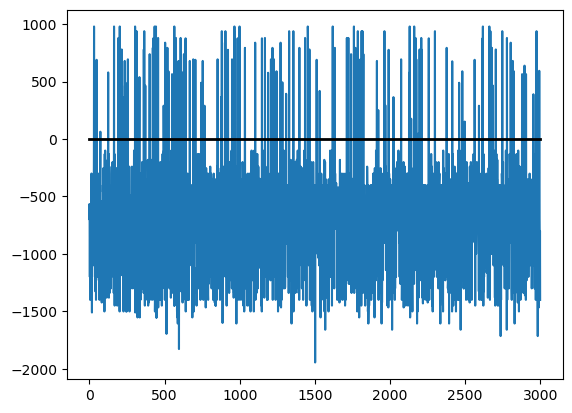

In [19]:
import agents
importlib.reload(agents)
from agents import A2C

agent = A2C(state_dim, action_dim, lr, gamma, entropy_coef = 0.01)
reward_history = []
for episode in range(max_episodes):
    state = env.reset()
    reference_frame = state
    state_lbp_top = agent.get_lbp_top_feature(reference_frame, state)
    state_tensor = torch.tensor([state_lbp_top], dtype=torch.float32).to(device)
    total_reward = 0
    step = 0
    states = []
    actions = []
    log_probs = []
    rewards = []
    entropies = []

    while True:
        action, log_prob, entropy = agent.select_action(state_tensor)
        next_state, reward, terminated, truncated = env.step(action)
        next_state_lbp_top = agent.get_lbp_top_feature(reference_frame, next_state)
        next_state_tensor = torch.tensor([next_state_lbp_top], dtype=torch.float32).to(device)
        total_reward += reward

        states.append(state_tensor)
        actions.append(torch.tensor([action], dtype=torch.float32).to(device))
        log_probs.append(log_prob)
        rewards.append(torch.tensor([reward], dtype=torch.float32).to(device))
        entropies.append(entropy)

        if terminated or truncated:
            break

        state = next_state
        state_tensor = next_state_tensor
        step += 1

    states = torch.cat(states)
    actions = torch.cat(actions)
    log_probs = torch.cat(log_probs)
    rewards = torch.cat(rewards)
    entropies = torch.cat(entropies)

    agent.train(states, log_probs, rewards, entropies, state_tensor)
    reward_history.append(total_reward)
    print(f"Episode: {episode}, Total Reward: {total_reward}")

plt.plot(reward_history)
plt.plot([0, len(reward_history)], [0, 0], 'k-', lw=2)
plt.show()

In [28]:
import agents
importlib.reload(agents)
from agents import DQNAgent



agent = DQNAgent((1, 224, 224), action_dim, lr, gamma, epsilon_start, epsilon_end, epsilon_decay)
reward_history = []
for episode in range(max_episodes):
    state = env.reset()
    total_reward = 0
    step = 0

    while True:
        action = agent.act(state)
        next_state, reward, terminated, truncated = env.step(action)
        total_reward += reward

        agent.remember(state, action, reward, next_state, terminated)
        agent.replay(batch_size)

        if step % update_target_interval == 0:
            agent.update_target_network()

        if terminated or truncated:
            break

        state = next_state
        step += 1
    reward_history.append(total_reward)
    print(f"Episode: {episode}, Total Reward: {total_reward}")
plt.plot(reward_history)
plt.plot([0, len(reward_history)], [0, 0], 'k-', lw=2)
plt.show()

Episode: 0, Total Reward: -1423
Episode: 1, Total Reward: -460
Episode: 2, Total Reward: -570
Episode: 3, Total Reward: -1340
Episode: 4, Total Reward: -1501
Episode: 5, Total Reward: -1200
Episode: 6, Total Reward: -1400
Episode: 7, Total Reward: -400
Episode: 8, Total Reward: -773
Episode: 9, Total Reward: -400
Episode: 10, Total Reward: -301
Episode: 11, Total Reward: -130
Episode: 12, Total Reward: -900
Episode: 13, Total Reward: -570
Episode: 14, Total Reward: -253
Episode: 15, Total Reward: -1501
Episode: 16, Total Reward: -1400
Episode: 17, Total Reward: -700
Episode: 18, Total Reward: 794
Episode: 19, Total Reward: -700
Episode: 20, Total Reward: -1261
Episode: 21, Total Reward: -460
Episode: 22, Total Reward: -240
Episode: 23, Total Reward: -900
Episode: 24, Total Reward: -600
Episode: 25, Total Reward: -700
Episode: 26, Total Reward: -1000
Episode: 27, Total Reward: -350
Episode: 28, Total Reward: -400
Episode: 29, Total Reward: 980
Episode: 30, Total Reward: -1120
Episode: 3

KeyboardInterrupt: 